In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import yaml
import os

load_dotenv()


API_KEY = os.getenv("api_key")
BASE_URL = os.getenv("base_url")

client = OpenAI(
    api_key=API_KEY,  # Replace with your actual API key
    base_url=BASE_URL
)
print("Config loaded")


Config loaded


In [ ]:
response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[
                {"role": "system", "content": "Give json output like column name, data type and min and max length"},
                {"role": "user", "content": "Generate a dataset schema with 5 columns for transaction data. Take the best transaction dataset from kaggle"}
            ]
        )
print(response.choices[0].message.content)

In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s"
)
logger = logging.getLogger(__name__)

import os
from dotenv import load_dotenv
from openai import OpenAI
from schema_agent import SchemaAgent
from schema_models import SchemaPrompt
from generator_agent import GeneratorAgent

# ✅ Load .env variables FIRST
load_dotenv()
API_KEY = os.getenv("api_key")
BASE_URL = os.getenv("base_url")

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)
logger.info("Config loaded")


# Instantiate agent
schema_agent = SchemaAgent(client)
logging.info("Schema agent initiated")
# Define prompt
schema_prompt = SchemaPrompt(
    use_case="Transaction fraud detection",
    prompt='''Generate a User info dataset 
    schema similar to top User info datasets on Kaggle.Creating this.
      Include fields like user name, login time, session time. Need this data set to train a fraud user detection ML model. Decide yourself'''
)

# Get structured output
schema_object = schema_agent.generate_from_prompt(schema_prompt)
logging.info("Schema generated")
# Print result
print(schema_object.model_dump_json(indent=2))
#initiate and run generator agent
Generator_agent = GeneratorAgent(client)
logging.info("Generator agent initiated")
gendata = Generator_agent.generate_sample(schema_prompt, schema_object)
logging.info("Generated data sample of size 200")
print(gendata)

2025-06-10 21:59:42,315 — INFO — Config loaded
2025-06-10 21:59:42,316 — INFO — Schema agent initiated
2025-06-10 21:59:42,708 — INFO — HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-06-10 21:59:59,669 — INFO — Schema generated
2025-06-10 21:59:59,670 — INFO — Generator agent initiated
2025-06-10 21:59:59,833 — INFO — HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


{
  "use_case": "Transaction fraud detection",
  "columns": [
    {
      "name": "user_id",
      "type": "int",
      "format": null,
      "values": null
    },
    {
      "name": "username",
      "type": "string",
      "format": null,
      "values": null
    },
    {
      "name": "email",
      "type": "string",
      "format": null,
      "values": null
    },
    {
      "name": "age",
      "type": "int",
      "format": null,
      "values": null
    },
    {
      "name": "gender",
      "type": "categorical",
      "format": null,
      "values": [
        "M",
        "F",
        "Other"
      ]
    },
    {
      "name": "registration_date",
      "type": "datetime",
      "format": "%Y-%m-%d",
      "values": null
    },
    {
      "name": "last_login_time",
      "type": "datetime",
      "format": "%Y-%m-%d %H:%M:%S",
      "values": null
    },
    {
      "name": "session_duration_seconds",
      "type": "int",
      "format": null,
      "values": null
    },
 

2025-06-10 22:00:26,025 — INFO — HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-06-10 22:01:17,836 — INFO — Generated data sample of size 200


      user_id          username                       email   age  gender  \
0    user_001           amber62  carriemckenzie@example.net   118   Other   
1    user_002         jmcdonald   cortezjessica@example.com  1159  Female   
2    user_003       stevensgary          eric56@example.org   677   Other   
3    user_004        perezamber        trobbins@example.com  1004    Male   
4    user_005  fitzgeraldangela         rgreene@example.org  2248   Other   
..        ...               ...                         ...   ...     ...   
195  user_196             fshaw         jenna99@example.org  8326   Other   
196  user_197        brendahahn      jamesbanks@example.org    35   Other   
197  user_198    maryfitzgerald        sstewart@example.net  6778  Female   
198  user_199      perryfelicia        jordan05@example.org  4546   Other   
199  user_200     russellsandra          ssmith@example.net  4373  Female   

      registration_date     last_login_time  session_duration_seconds  \
0 

In [6]:
gendata.to_csv("synthetic_data.csv", index=False)

In [5]:
gendata["age"] = ((gendata["age"]/10000)*100).astype(int)

In [ ]:
from openai import OpenAI
from schema_agent import SchemaAgent
from schema_models import SchemaPrompt
agent_schema = SchemaAgent(client)
csv_schemaprompt = SchemaPrompt(
    use_case = "Iris dataset transaction",
    csv_path = "C:\\Users\\HOME\\Downloads\\archive\\iris.csv"
)
csv_schema = agent_schema.generate_from_csv(csv_schemaprompt)
print(csv_schema.model_dump_json(indent=2))


{
  "use_case": "Iris dataset transaction",
  "columns": [
    {
      "name": "Id",
      "type": "int",
      "format": null,
      "values": null
    },
    {
      "name": "SepalLengthCm",
      "type": "float",
      "format": null,
      "values": null
    },
    {
      "name": "SepalWidthCm",
      "type": "float",
      "format": null,
      "values": null
    },
    {
      "name": "PetalLengthCm",
      "type": "float",
      "format": null,
      "values": null
    },
    {
      "name": "PetalWidthCm",
      "type": "float",
      "format": null,
      "values": null
    },
    {
      "name": "Species",
      "type": "categorical",
      "format": null,
      "values": [
        "Iris-setosa",
        "Iris-versicolor",
        "Iris-virginica"
      ]
    }
  ]
}


2025-06-10 22:12:24,570 — INFO — Detected metadata:
2025-06-10 22:12:24,572 — INFO — {
    "columns": {
        "user_id": {
            "sdtype": "id"
        },
        "username": {
            "sdtype": "categorical"
        },
        "email": {
            "pii": true,
            "sdtype": "email"
        },
        "age": {
            "sdtype": "numerical"
        },
        "gender": {
            "sdtype": "categorical"
        },
        "registration_date": {
            "sdtype": "datetime"
        },
        "last_login_time": {
            "sdtype": "datetime"
        },
        "session_duration_seconds": {
            "sdtype": "numerical"
        },
        "ip_address": {
            "pii": true,
            "sdtype": "ipv6_address"
        },
        "device_type": {
            "sdtype": "categorical"
        },
        "os": {
            "sdtype": "categorical"
        },
        "browser": {
            "sdtype": "categorical"
        },
        "country": {
  

{'user_id': {'sdtype': 'id'}, 'username': {'sdtype': 'categorical'}, 'email': {'pii': True, 'sdtype': 'email'}, 'age': {'sdtype': 'numerical'}, 'gender': {'sdtype': 'categorical'}, 'registration_date': {'sdtype': 'datetime'}, 'last_login_time': {'sdtype': 'datetime'}, 'session_duration_seconds': {'sdtype': 'numerical'}, 'ip_address': {'pii': True, 'sdtype': 'ipv6_address'}, 'device_type': {'sdtype': 'categorical'}, 'os': {'sdtype': 'categorical'}, 'browser': {'sdtype': 'categorical'}, 'country': {'sdtype': 'categorical'}, 'is_fraudulent': {'sdtype': 'categorical'}}
{
    "columns": {
        "user_id": {
            "sdtype": "id"
        },
        "username": {
            "sdtype": "categorical"
        },
        "email": {
            "pii": true,
            "sdtype": "email"
        },
        "age": {
            "sdtype": "numerical"
        },
        "gender": {
            "sdtype": "categorical"
        },
        "registration_date": {
            "sdtype": "datetime"
   

2025-06-10 22:12:24,813 — INFO — Fitting table  metadata
2025-06-10 22:12:24,814 — INFO — Fitting formatters for table 
2025-06-10 22:12:24,817 — INFO — Setting the configuration for the ``HyperTransformer`` for table 
2025-06-10 22:12:24,820 — INFO — Fitting HyperTransformer for table 
2025-06-10 22:12:24,848 — INFO — {'EVENT': 'Fit processed data', 'TIMESTAMP': datetime.datetime(2025, 6, 10, 22, 12, 24, 848075), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.22.1_6a653fa006ea4973974f2000b2bfbb1f', 'TOTAL NUMBER OF TABLES': 1, 'TOTAL NUMBER OF ROWS': 200, 'TOTAL NUMBER OF COLUMNS': 11}
2025-06-10 22:12:24,852 — INFO — Guidance: There are no missing values in column age. Extra column not created.
2025-06-10 22:12:27,081 — INFO — Guidance: There are no missing values in column registration_date. Extra column not created.
2025-06-10 22:12:27,121 — INFO — Guidance: There are no missing values in column last_login_time. Extra column not created.
2025-06

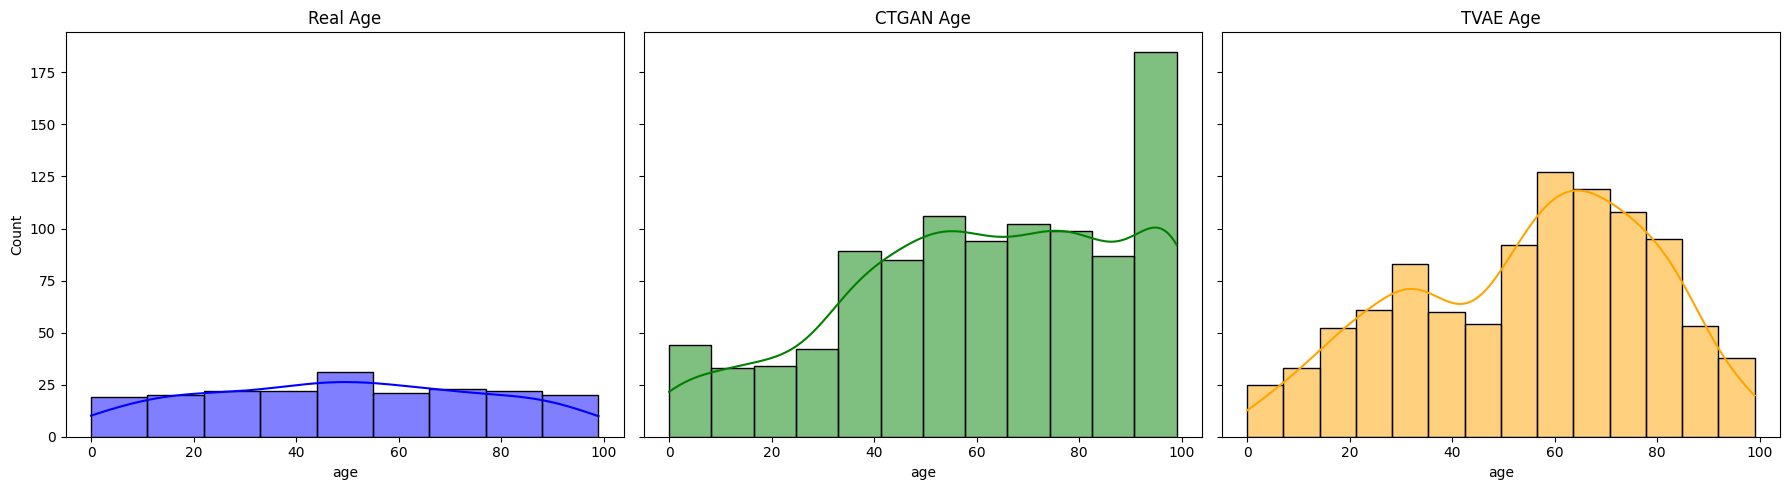

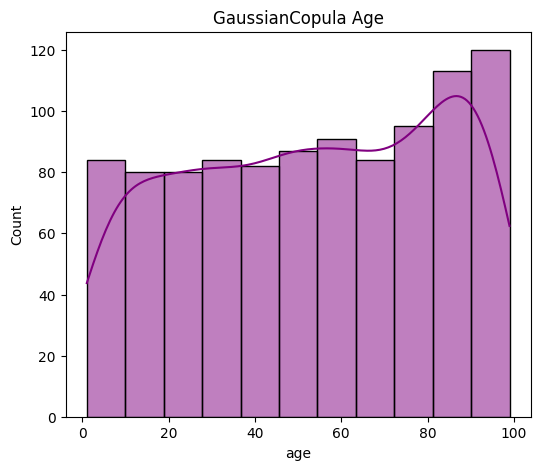

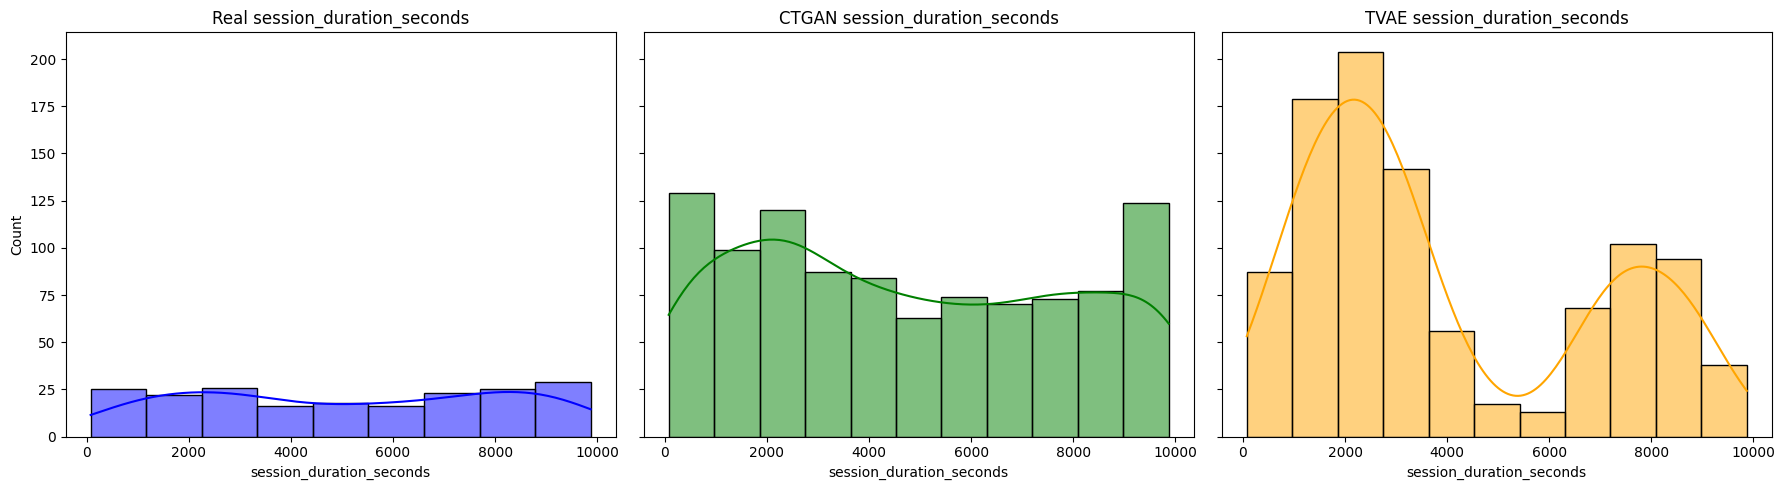

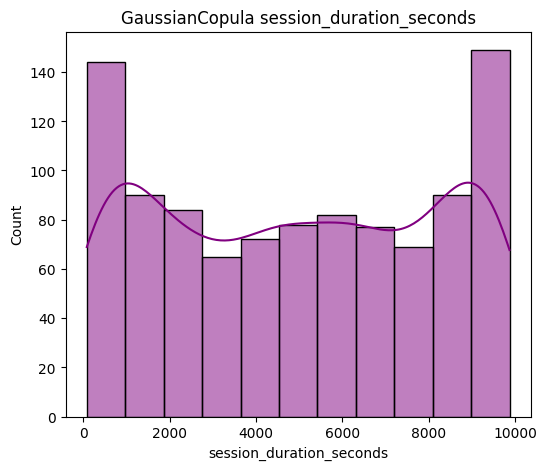

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer, GaussianCopulaSynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=gendata)
print(metadata.columns)

print(metadata)

# Train synthesizers
ctgan = CTGANSynthesizer(metadata)
ctgan.fit(gendata)
ctgan_sample = ctgan.sample(1000)

tvae = TVAESynthesizer(metadata)
tvae.fit(gendata)
tvae_sample = tvae.sample(1000)

copula = GaussianCopulaSynthesizer(metadata)
copula.fit(gendata)
copula_sample = copula.sample(1000)

# Plot comparison
def plot_distribution_comparison(real, synthetic_list, title):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    sns.histplot(real, color='blue', kde=True, ax=axes[0])
    axes[0].set_title(f'Real {title}')
    
    sns.histplot(synthetic_list[0], color='green', kde=True, ax=axes[1])
    axes[1].set_title(f'CTGAN {title}')
    
    sns.histplot(synthetic_list[1], color='orange', kde=True, ax=axes[2])
    axes[2].set_title(f'TVAE {title}')
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.histplot(synthetic_list[2], color='purple', kde=True)
    plt.title(f'GaussianCopula {title}')
    plt.show()

plot_distribution_comparison(gendata["age"], [ctgan_sample["age"], tvae_sample["age"], copula_sample["age"]], "Age")
plot_distribution_comparison(gendata["session_duration_seconds"], [ctgan_sample["session_duration_seconds"], tvae_sample["session_duration_seconds"], copula_sample["session_duration_seconds"]], "session_duration_seconds")


In [8]:
ctgan_sample.to_csv("ctgandata.csv", index=False)